# Test HAND processing and stitching

# Import modules and load DEM from datacube

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid

import pyproj
from affine import Affine
import xarray as xr
import os
import geopandas as gpd
from shapely.geometry import Point, Polygon
import rasterio

import warnings
warnings.filterwarnings('ignore')

In [3]:
import datacube
from datacube.helpers import write_geotiff

dc = datacube.Datacube()

In [4]:
dirmap=(4, 2, 1, 128, 64, 32, 16, 8)
routing='d8'

In [5]:
def fix_dem(grid):
    depressions = grid.detect_depressions('dem')
    n_depression = (depressions).sum()
    flats = grid.detect_flats('dem')
    n_flat = (flats).sum()
    i=0
    while n_depression > 0 or n_flat>0:
        print("fill depressions and resolve flats iter:", i, n_depression, n_flat)
        pre_depression = n_depression
        pre_flat = n_flat
    
        grid.fill_depressions(data='dem', out_name='dem')
        grid.resolve_flats('dem', out_name='dem')
    
        depressions = grid.detect_depressions('dem')
        n_depression = (depressions).sum()
        flats = grid.detect_flats('dem')
        n_flat = (flats).sum()
    
        if n_depression== pre_depression and n_flat==flat: break
        i+=1

In [6]:
def hand(dem, band='elevation', acc_thresh=10000, dirmap=dirmap, routing=routing):
    coords = list(dem.coords.keys())
    if 'x' in coords: coord_x, coord_y = 'x', 'y' 
    else: coord_x, coord_y = 'longitude', 'latitude'
    
    dem[band] = dem[band].where(dem[band]!=dem[band].attrs['nodata'])
    dem[band] = dem[band].where(dem[band] > -1000)
    xres = dem[coord_x].values[1]-dem[coord_x].values[0]
    yres = dem[coord_y].values[1]-dem[coord_y].values[0]
    x_ref = dem[coord_x].values[0]
    y_ref = dem[coord_y].values[0]
    
    grid = Grid(nodata = np.nan, 
                crs = pyproj.Proj('+init=epsg:%s'%dem[band].attrs['crs'].split(':')[1]))
    grid.add_gridded_data(dem[band].values.squeeze(),
                      data_name = 'dem', affine = Affine(xres, 0, x_ref, 0, yres, y_ref),
                      shape = dem[band].values.squeeze().shape, 
                      nodata = np.nan, 
                      crs = pyproj.Proj('+init=epsg:%s'%dem[band].attrs['crs'].split(':')[1]))
    fix_dem(grid)
    
    grid.flowdir(data='dem', out_name='dir',astype=np.float32, dirmap=dirmap, routing=routing)
    grid.accumulation(data='dir', out_name='acc', pad=False, dirmap=dirmap, routing=routing, astype=np.float32)
    if not acc_thresh: 
            acc_thresh = np.nanpercentile(grid.acc, 90)
            #print("accumulation threshold:", acc_thresh)
            #acc = grid.acc*grid.streams
            #acc_thresh = np.nanpercentile(acc[acc>0],1)
    print("accumulation threshold:", acc_thresh)
    print("90 percentile accumulation:", np.nanpercentile(grid.acc, 90))
    dem['acc'] = (coord_y, coord_x), grid.acc.astype(np.float32)
    dem['hand'] = (coord_y, coord_x), grid.compute_hand('dir', 'dem', grid.acc > acc_thresh, 
                                                            dirmap=dirmap, routing=routing, 
                                                            inplace=False,astype=np.float32)
    dem['dir'] = (coord_y, coord_x), grid.dir.astype(np.float32)
    

In [7]:
data = dc.load(product='srtm', dask_chunks={})
extent = data.geobox.extent.to_crs('EPSG:6933').boundingbox
print(extent)

BoundingBox(left=-3087587.7697979035, bottom=-5270155.408293141, right=5885689.8970962865, top=5358591.385916094)


In [8]:
xs = 7290
ys = 7290
buffer = xs/9

res = 30
# tile zize in m, and grid boundary

bres = buffer*res
left, right = np.floor(extent.left/bres)*bres, np.ceil(extent.right/bres)*bres
bottom, top = np.floor(extent.bottom/bres)*bres, np.ceil(extent.top/bres)*bres
bbox = left, bottom, right, top
print(bbox)

(-3110400.0, -5273100.0, 5904900.0, 5370300.0)


In [9]:
xfs=(right-left)/res #301320;
yfs=(top-bottom)/res #357210;
# number of tiles
nx=np.ceil(xfs/xs).astype(int)
ny=np.ceil(yfs/ys).astype(int)
xf0=left
yf0=top
xres=30
yres=-30

print("tile size", xs, ys)
print("number of tiles", nx, ny)

tile size 7290 7290
number of tiles 42 49


In [10]:
startx = int(nx/2)
starty = int(ny/2)

for xi in range(startx, nx):
    for yi in range(starty, ny):

        # output name
        outname=f"hand_{xi}_{yi}.tif"
        print(outname)
        # break if done
        if os.path.exists(outname): continue
 
        # buffered boundary
        x0=(xi-1)*xs-buffer
        y0=(yi-1)*ys-buffer
        x1=x0+xs+buffer*2
        y1=y0+ys+buffer*2
 
        # chop outside input range
        if x0<0:
            xoff=0
            trim_xoff=0
        else:
            xoff=x0
            trim_xoff=buffer
        #
        if (y0<0):
            yoff=0
            trim_yoff=0
        else:
            yoff=y0
            trim_yoff=buffer
        #
        if (x1>xfs):
            xsize=xfs-xoff
            trim_xsize=xsize-trim_xoff
        else:
            xsize=x1-xoff
            trim_xsize=xsize-trim_xoff-buffer
        #
        if y1>yfs:
            ysize=yfs-yoff
            trim_ysize=ysize-trim_yoff
        else:
            ysize=y1-yoff
            trim_ysize=ysize-trim_yoff-buffer
        #

        dem_query = { 'y': (yf0+(yoff+ysize)*yres, yf0+yoff*yres), 'x': (xf0+xoff*xres, xf0+(xoff+xsize)*xres), 'crs': 'EPSG:6933', 
                 'output_crs':'EPSG:6933', 'resolution': (yres, xres)}
        print(dem_query)
        dem_tile = dc.load(product = 'srtm', measurements=['elevation'], **dem_query).squeeze()
        break
        hand(dem_tile)
        
        helpers.write_geotiff(outname, dem_tile.hand)

    break

hand_21_24.tif
{'y': (97200.0, 364500.0), 'x': (1239300.0, 1506600.0), 'crs': 'EPSG:6933', 'output_crs': 'EPSG:6933', 'resolution': (-30, 30)}


In [11]:
hand(dem_tile)

fill depressions and resolve flats iter: 0 1541323 6005334
fill depressions and resolve flats iter: 1 9437 12082
fill depressions and resolve flats iter: 2 3305 3305
fill depressions and resolve flats iter: 3 973 1975
accumulation threshold: 10000
99 percentile accumulation: 4752.0


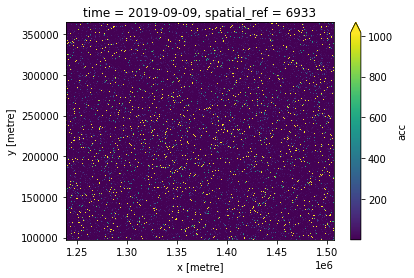

In [14]:
dem_tile.acc.plot.imshow(robust=True);

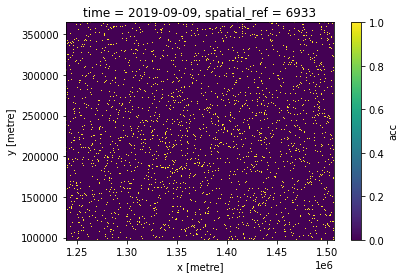

In [22]:
(dem_tile.acc>200).plot.imshow(robust=True);

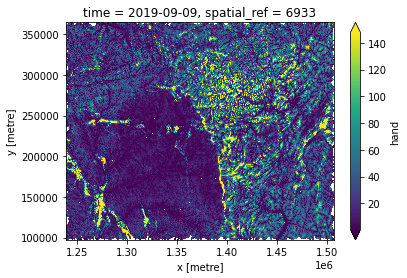

In [15]:
dem_tile.hand.plot.imshow(robust=True);

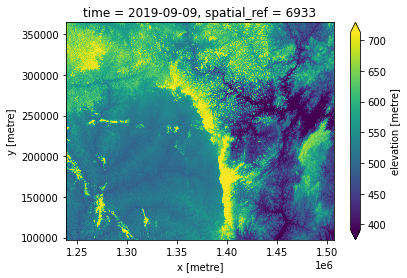

In [18]:
dem_tile.elevation.plot.imshow(robust=True);

In [ ]:
!ls